In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow

In [21]:
sns.set_style("whitegrid")

In [22]:
df = pd.read_csv("data/heart_disease_uci.csv")
print("Data loaded successfully.")

Data loaded successfully.


In [23]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [24]:
df = df.rename(columns={'num': 'target'})

In [25]:
print("Missing values:\n", df.isna().sum())
print(f"Shape before cleaning: {df.shape}")

Missing values:
 id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64
Shape before cleaning: (920, 16)


In [26]:
cols_to_drop = ['id', 'dataset', 'ca', 'thal'] 
df_clean = df.drop(columns=cols_to_drop)

In [27]:
num_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
for col in num_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

In [28]:
cat_cols = ['fbs', 'restecg', 'exang', 'slope']
for col in cat_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

/var/folders/p5/x75z801n01z15xp10rx4v9q00000gn/T/ipykernel_52489/2826105339.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])


In [29]:
print("Missing values after cleaning:\n", df_clean.isna().sum())
print(f"Shape after cleaning: {df_clean.shape}")

Missing values after cleaning:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
target      0
dtype: int64
Shape after cleaning: (920, 12)


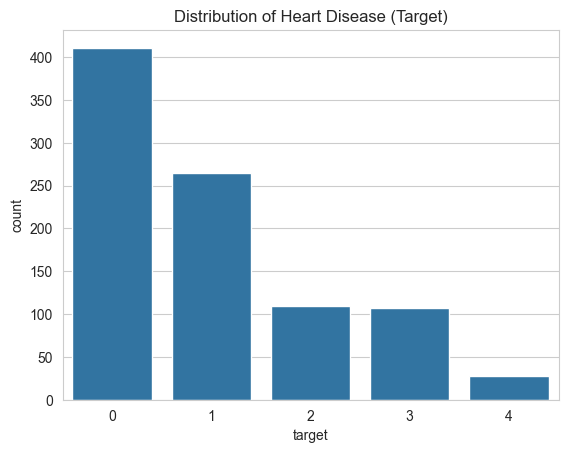

In [30]:
sns.countplot(x=df['target'])
plt.title("Distribution of Heart Disease (Target)")
plt.show()

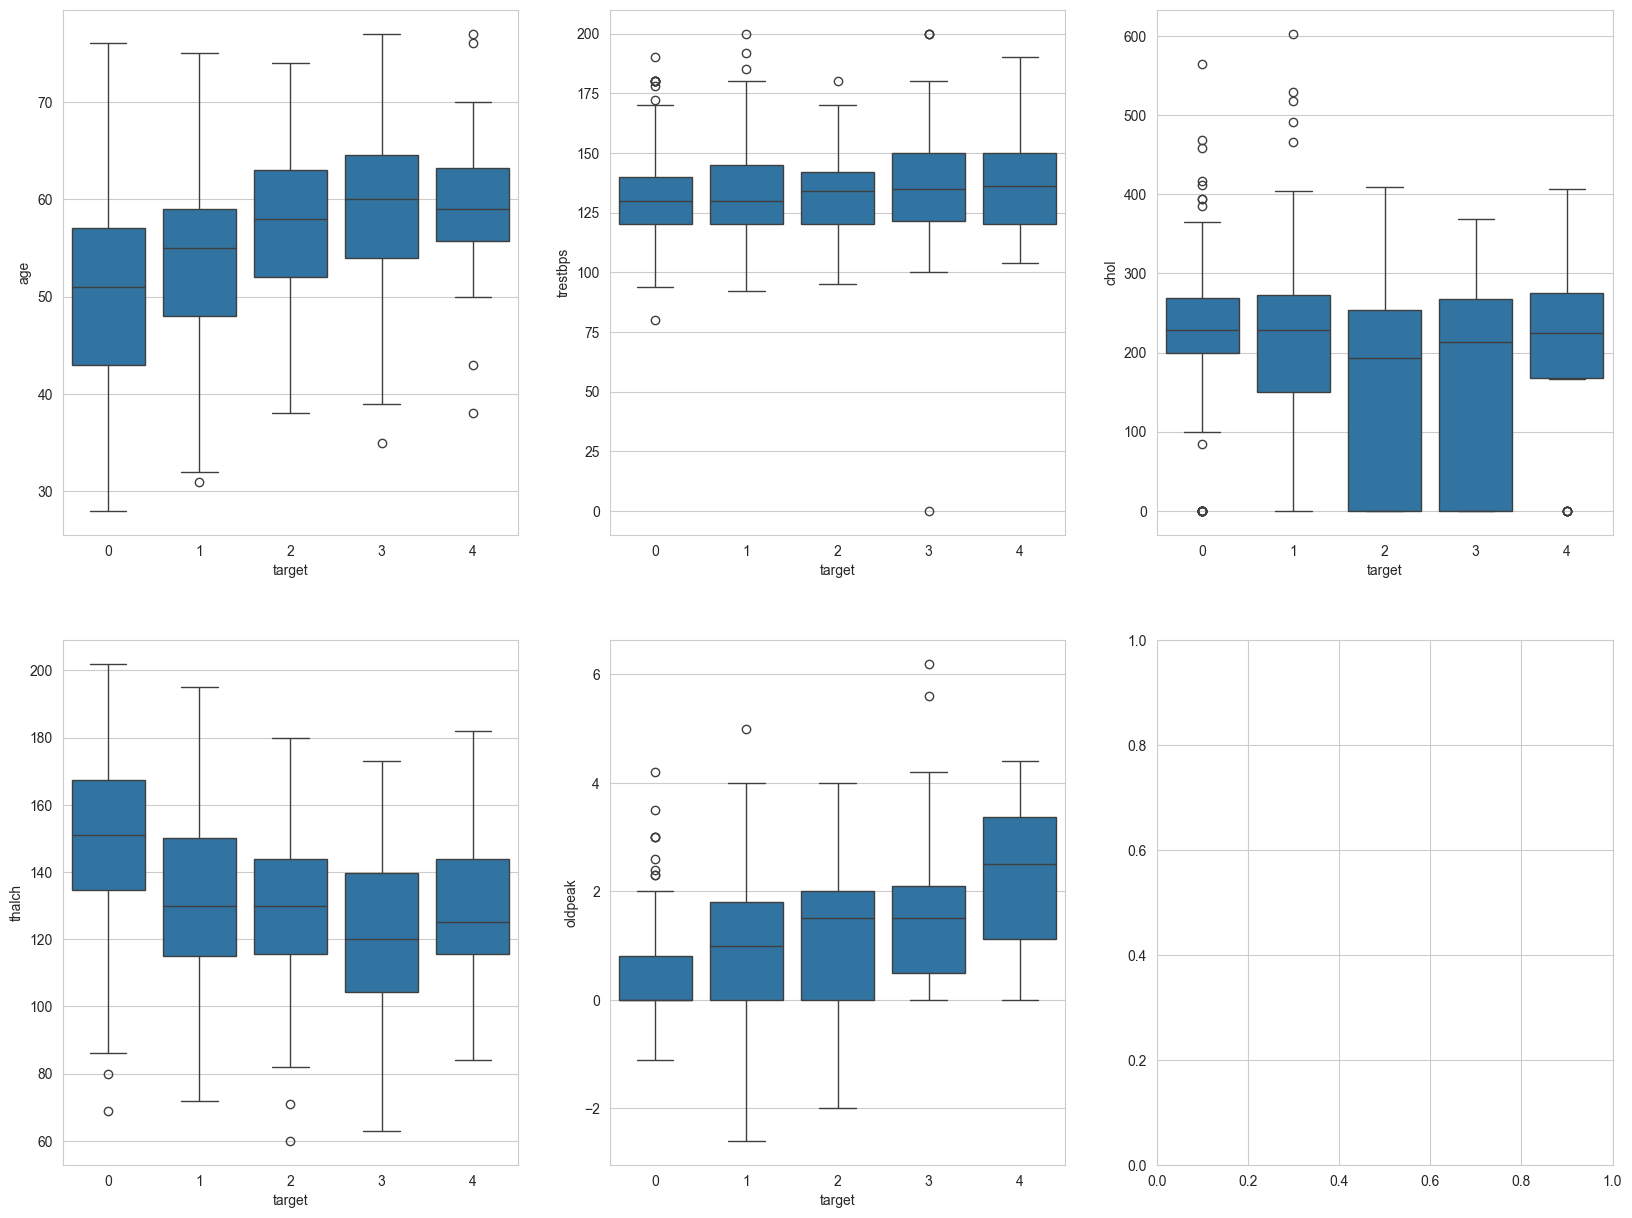

In [31]:
dims = (2, 3)
f, axes = plt.subplots(dims[0], dims[1], figsize=(20, 15))
axis_i, axis_j = 0, 0

features_to_plot = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

for col in df.columns:
    if col not in features_to_plot:
        continue
        
    sns.boxplot(x=df['target'], y=df[col], ax=axes[axis_i, axis_j])
    
    axis_j += 1
    if axis_j == dims[1]:
        axis_i += 1
        axis_j = 0

The box plots reveal clear distinctions between patients with no heart disease (Target 0) and those with various stages of heart disease (Targets 1-4).

* Thalach (Max Heart Rate): This is a strong inverse predictor. Healthy patients (0) tend to have significantly higher maximum heart rates. As the disease stage progresses (1 $\rightarrow$ 4), the median heart rate drops noticeably.
* Oldpeak (ST depression): This appears to be the strongest differentiator. The median oldpeak for healthy patients is near 0. For disease stages 1-4, the value jumps significantly.
* Age: There is a subtle trend where older patients are more represented in the disease categories, though there is significant overlap.

In [32]:
df_clean.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,target
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0


In [33]:
df_clean['target'] = df_clean['target'].astype(int)

categorical_cols_to_encode = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope']
existing_cat_cols = [col for col in categorical_cols_to_encode if col in df_clean.columns]
df_encoded = pd.get_dummies(df_clean, columns=existing_cat_cols, drop_first=True)

In [34]:
import mlflow
import mlflow.sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, accuracy_score
from mlflow.models.signature import infer_signature

In [35]:
from sklearn.model_selection import train_test_split
X = df_encoded.drop(["target"], axis=1)
y = df_encoded['target']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123, stratify=y)

In [37]:
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model
    
    def predict(self, context, model_input):
        return self.model.predict_proba(model_input)

/opt/anaconda3/envs/mlops-labs/lib/python3.14/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [38]:
run_name = 'multiclass_neural_network'

with mlflow.start_run(run_name=run_name):
    pipeline = make_pipeline(
        StandardScaler(),
        MLPClassifier(
            hidden_layer_sizes=(32, 32), 
            max_iter=2000, 
            early_stopping=True, 
            validation_fraction=0.1,
            alpha=0.01,
            random_state=123
        )
    )
    
    print("Training Multiclass Neural Network...")
    pipeline.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, pipeline.predict(X_train))
    test_acc = accuracy_score(y_test, pipeline.predict(X_test))
    
    mlflow.log_param('layers', "(128, 64)")
    mlflow.log_param('model_type', "Multiclass_MLP")
    mlflow.log_metric('train_accuracy', train_acc)
    mlflow.log_metric('test_accuracy', test_acc)
    
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    wrappedModel = SklearnModelWrapper(pipeline)
    signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
    
    mlflow.pyfunc.log_model(
        "heart_disease_multiclass",
        python_model=wrappedModel,
        signature=signature
    )

/opt/anaconda3/envs/mlops-labs/lib/python3.14/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/11/17 19:15:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Training Multiclass Neural Network...
Train Accuracy: 0.5693
Test Accuracy: 0.5543


/opt/anaconda3/envs/mlops-labs/lib/python3.14/site-packages/mlflow/pyfunc/__init__.py:3285: UserWarning: An input example was not provided when logging the model. To ensure the model signature functions correctly, specify the `input_example` parameter. See https://mlflow.org/docs/latest/model/signatures.html#model-input-example for more details about the benefits of using input_example.
  color_warning(


In [39]:
import time
from mlflow.tracking import MlflowClient

In [42]:
search_name = "multiclass_neural_network"
model_name = "heart_disease_multiclass_production"

In [43]:
runs = mlflow.search_runs(filter_string=f'tags.mlflow.runName = "{search_name}"')
latest_run_id = runs.iloc[0].run_id

print(f"Found Run ID: {latest_run_id}")

Found Run ID: 942a1bc779fd403d873aec9ef78c4c44


In [45]:
print(f"Registering model as '{model_name}'...")
model_version = mlflow.register_model(f"runs:/{latest_run_id}/heart_disease_multiclass", model_name)

time.sleep(5)

Registered model 'heart_disease_multiclass_production' already exists. Creating a new version of this model...
2025/11/17 19:18:30 WARNING mlflow.tracking._model_registry.fluent: Run with id 942a1bc779fd403d873aec9ef78c4c44 has no artifacts at artifact path 'heart_disease_multiclass', registering model based on models:/m-311f8ac6ccaf4b30bfcbafc2b731d9cd instead


Registering model as 'heart_disease_multiclass_production'...


Created version '1' of model 'heart_disease_multiclass_production'.


In [46]:
print("Transitioning to Production...")
client = MlflowClient()

client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production"
)

print(f"Success! Model '{model_name}' (Version {model_version.version}) is now in PRODUCTION.")

Transitioning to Production...
Success! Model 'heart_disease_multiclass_production' (Version 1) is now in PRODUCTION.


/var/folders/p5/x75z801n01z15xp10rx4v9q00000gn/T/ipykernel_52489/1091844160.py:4: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


In [50]:
prod_model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")

patient_data = X_test.iloc[[10]] 
actual_stage = y_test.iloc[10]

In [51]:
prediction_probs = prod_model.predict(patient_data)
predicted_stage = prediction_probs.argmax()

In [52]:
print(f"\n--- Patient Diagnosis Report ---")
print(f"Patient Vitals:\n{patient_data.to_string(index=False)}")
print(f"\nModel Prediction:")
print(f"   Predicted Stage: {predicted_stage} (Confidence: {prediction_probs.max():.2%})")
print(f"   Actual Stage:    {actual_stage}")

if predicted_stage == actual_stage:
    print("Diagnosis Matched")
else:
    print("Diagnosis Mismatched")


--- Patient Diagnosis Report ---
Patient Vitals:
 age  trestbps  chol  thalch  oldpeak  sex_Male  cp_atypical angina  cp_non-anginal  cp_typical angina  fbs_True  restecg_normal  restecg_st-t abnormality  exang_True  slope_flat  slope_upsloping
  56     120.0  85.0   140.0      0.0      True               False           False              False     False            True                     False       False        True            False

Model Prediction:
   Predicted Stage: 0 (Confidence: 44.00%)
   Actual Stage:    0
Diagnosis Matched
